# Bayesian Linear Regression

In this notebook, we explore linear regression under the Bayesian framework. While traditional or frequentist linear regression treats the model parameters(such as the slope and intercept) as **deterministic**, Bayesian linear regression assumes that these parameters come from a hidden or **latent probability distribution**. The Bayesian framework has the clear benefit of incorporating **prior** domain knowledge an individual may have on a given dataset or application. Furthermore, a Bayesian treatment of regression can also help avoid overfitted or overly-complex models, issues that often plague frequentist maximum likelihood methods (Bishop 152). Let's start with a quick rundown of traditional linear regression.

## Notation

We will denote constants as lower case letters $a$, vectors as lower case letters with a vector symbol $\vec{a}$, and matrices as upper case bolded letters $\mathbf{A}$. 

## Frequentist Treatment

Suppose our data consists of i.i.d. target/response variables $t_i$ and corresponding predictor/explanatory variables $\vec{x_i} = (x_{i,0}, x_{i,1}, \ldots, x_{i,N-1})$. Rather than using the original data, it is common to instead use extracted/preprocessed features(see [monomial basis](https://en.wikipedia.org/wiki/Basis_function) and [RBF](https://en.wikipedia.org/wiki/Radial_basis_function) for examples), which we will denote $\vec{\phi_i} = \left(\phi_0(\vec{x_i}), \phi_1(\vec{x_i}), \ldots, \phi_{M-1}(\vec{x_i})\right)$. We then assume that $t_i$ has a linear relationship with $\vec{\phi_i}$. Adding random noise $\epsilon_i$, we have

\begin{align}
    t_i = \vec{w}^T\vec{\phi_i} + \epsilon_i
\end{align}

where $\vec{w} = (w_0, w_1, \ldots, w_{N-1})$ are our model parameters/coefficients. 

In the case of simple linear regression, 

\begin{align}
    \vec{x_i} &= x_i\\
    \vec\phi_i &= \left(\phi_0(x_i), \phi_1(x_i)\right) = (1, x_i) \\
    \vec{w} &= (w_0, w_1) \\
    \implies t_i &= \vec{w}^T\vec{\phi_i} + \epsilon_i = w_0 + w_1x_i + \epsilon_i
\end{align}

It is also common to assume that the random noise $\epsilon_i$ comes from a Gaussian distribution with zero mean and inverse variance(precision) $\beta$,

\begin{align}
    \epsilon_i \sim \mathcal{N}\left(0, \beta^{-1}\right)
\end{align}

In [34]:
# simple linear regression with no basis function for simplicity and sake of visualization
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)

dim = 1
# generate toy data
mu = 5
sigma = 2
numpoints = 100
x = np.random.normal(mu, sigma, size = (numpoints, dim))

slope = 3
eps_mu = 0
beta = 0.25
eps = np.random.normal(eps_mu, 1/beta, size = (numpoints, dim))
t = slope * x + eps

# phi is a column of ones next to the column of x's
phi = np.hstack((np.ones((numpoints, 1)), x))

Because adding a constant to a Gaussian distribution shifts the mean by that constant, we have 

\begin{align}
    t_i \sim \mathcal{N}\left(\vec{w}^T\vec{\phi_i}, \beta^{-1}\right) \quad \text{or} \quad p\left(t_i \Big| \vec{w}^T\vec{\phi_i}, \beta^{-1}\right) = \mathcal{N}\left(\vec{w}^T\vec{\phi_i}, \beta^{-1}\right)
\end{align}

We can then write the **likelihood function** and log-likelihood function as a product of the individual likelihoods/log-likelihoods due to independence 

\begin{align}
    L(\vec{w}) &= \prod_{n = 1}^{N} p\left(t_i \Big| \vec{w}^T\vec{\phi_i}, \beta^{-1}\right) = \prod_{n = 1}^{N} \frac{1}{\sqrt{2\pi \beta^{-1}}} \exp{\left(-\frac{1}{2}\frac{\left(t_n - \vec{w}^T\vec{\phi_i}\right)^2}{\beta^{-1}}\right)} \\
    &= \left(2\pi \beta^{-1}\right)^{-N/2} \exp{\left(-\frac{\beta}{2} \displaystyle\sum_{n = 1}^{N} \left(t_n - \vec{w}^T\vec{\phi_i}\right)^2 \right)} \\
    \log L(\vec{w}) &= -\frac{N}{2}\log(2\pi) + \frac{N}{2}\log(\beta) - \frac{\beta}{2}\displaystyle\sum_{n = 1}^{N}\left(t_n - \vec{w}^T\vec{\phi_i}\right)^2
\end{align}

**Maximizing** the log-likelihood is the same as minimizing the likelihood, so taking the gradient with respect to $\vec{w}$ and setting to zero yields the famous **normal equations**, 

\begin{align}
    \nabla_\vec{w} \log L(\vec{w}) &= - \beta\sum_{n = 1}^{N} \left(t_n - \vec{w}^T \vec{\phi_n}\right) \vec{\phi_n}^T = 0 \\
    \implies \vec{w_{ML}} &= \left(\mathbf{\Phi}^T\mathbf{\Phi}\right)^{-1} \mathbf{\Phi}^{-1} \vec{t}
\end{align}

where $\mathbf{\Phi} = \left(\vec{\phi_0}, \vec{\phi_1}, \ldots, \vec{\phi_N}\right)^T$ is often referred to as the **design matrix**.

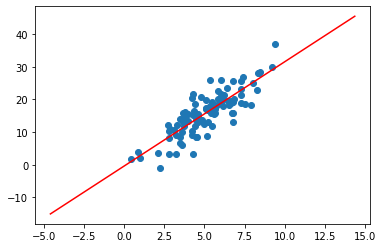

In [51]:
# pinv is generally avoided since singular matrices can cause problems
#w = np.linalg.pinv(phi.T @ phi) @ phi.T @ t

# use lstsq instead, it solves for x in Ax = b
w = np.linalg.lstsq(phi.T @ phi, phi.T @ t, rcond=None)[0]

# plot data and fitted reg. line
line_x_ls = np.linspace(np.min(x)-5, np.max(x) + 5, 100)
line_y_ls = w[0] + w[1]*line_x
plt.scatter(x, t)
plt.plot(line_x_ls, line_y_ls, 'r')
plt.show()

## Bayesian Treatment

Bayesian linear regression follows the same setup as the frequentist framework, except that we now assume that $\vec{w}$ belongs to a **prior** distribution. It turns out that because the likelihood function $L(\vec{w})$ is the exponential of a quadratic function of $\vec{w}$, this prior is a multivariate Gaussian distribution (Bishop 152)

\begin{align}
    \vec{w} \sim \mathcal{N}\left(\vec{m_0}, \mathbf{S}_0\right) \quad \text{or} \quad p(\vec{w}) = \mathcal{N}\left(\vec{w} \Big| \vec{m_0}, \mathbf{S}_0\right)
\end{align}

where $\vec{m_0}$ and $\mathbf{S}_0$ are the initial "guesses" of the mean and covariance of $\vec{w}$. The posterior distribution of $\vec{w}$ can then be found using Baye's Rule, 

\begin{align}
    p(\vec{w} | \vec{t} ) \propto p(\vec{t} | \vec{w}) p(\vec{w})
\end{align}

Note that $p(\vec{t} | \vec{w})$ is the likelihood given in the previous section (since we view $\vec{x}$ and $\beta$ as constant). The posterior distribution of a Gaussian will in turn be Gaussian, and given the prior and likelihood distributions (Bishop 90-93)

\begin{align}
    p(\vec{w}) &= \mathcal{N}\left(\vec{w} \Big| \vec{\mu}, \mathbf{\Lambda}^{-1}\right) \\
    p(\vec{t} | \vec{w}) &= \mathcal{N}\left(\vec{t} \Big| \mathbf{A}\vec{w} + \vec{b}, \mathbf{L}^{-1}\right) 
\end{align}

the posterior distribution will have the following form (Bishop 93)

\begin{align}
    p(\vec{w} | \vec{t}) = \mathcal{N}\left(\vec{w} \Big| \left(\mathbf{\Lambda} + \mathbf{A}^T\mathbf{L}\mathbf{A}\right)^{-1}\left(\mathbf{A}^T\mathbf{L}(\vec{t} - \vec{b}) + \mathbf{\Lambda} \vec{\mu}\right), \left(\mathbf{\Lambda} + \mathbf{A}^T\mathbf{L}\mathbf{A}\right)^{-1} \right)
\end{align}

This works out to be 

\begin{align}
    p(\vec{w}, \vec{t}) &= \mathcal{N}\left( \vec{w} \Big| \vec{m}_N, \mathbf{S}_N \right) \\
    \vec{m}_N &= \mathbf{S}_N\left(S_0^{-1} \vec{m_0} + \beta \mathbf{\Phi}^T \vec{t} \right) \\
    \mathbf{S}_N^{-1} &= \mathbf{S}_0^{-1} + \beta \mathbf{\Phi}^T\mathbf{\Phi}
\end{align}

Rather than maximizing the likelihood, we instead maximize the posterior, or **maximum a posteriori(MAP)** (which is actually equivalent to MLE if the prior is constant or uniform). In the case of a Gaussian posterior distribution, the mode coincides with the mean, thus 

\begin{align}
    \vec{w}_{MAP} = \vec{m}_N
\end{align}

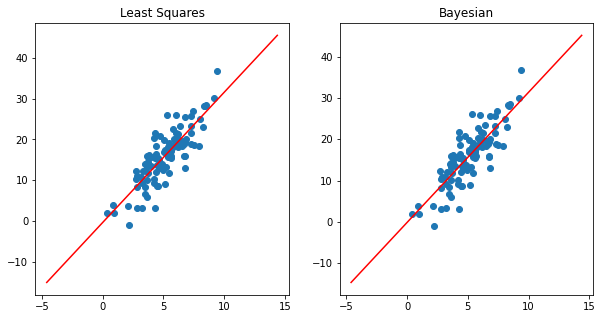

In [54]:
# suppose our prior tells us slope = 1 and y intercept = 0 with identity covar matrix
m_0 = np.array([[0], [1]])
S_0 = np.eye(2)
beta = 0.25

S_0inv = np.linalg.lstsq(S_0, np.eye(2), rcond = None)[0]
S_n = np.linalg.lstsq(S_0inv + beta * phi.T @ phi, np.eye(2), rcond = None)[0]
m_n = S_n @ (S_0inv @ m_0 + beta * phi.T @ t)

line_x_b = np.linspace(np.min(x)-5, np.max(x) + 5, 100)
line_y_b = m_n[0] + m_n[1]*line_x

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].title.set_text("Least Squares")
ax[0].scatter(x, t)
ax[0].plot(line_x_ls, line_y_ls, 'r')
ax[1].title.set_text("Bayesian")
ax[1].scatter(x, t)
ax[1].plot(line_x_b, line_y_b, 'r')
plt.show()

The fitted Bayesian model is almost identical to the frequentist model in this simple regression case, though differences in results will be more apparent with more complex or high dimensional data. In fact, if we consider an **isotropic prior**, where $S_0 = \alpha I$, maximizing the log-posterior(which is the sum of the log-likelihood and the log-prior) yields an identical solution to that of MLE. 

## Online Bayesian Regression

Large datasets often face computational and memory limitations, both of which motivate an **online** or **sequential** update scheme. Similar to stochastic gradient descent for frequentist regression, the online version of Bayesian regression not only allows model parameters to be updated without keeping the entire dataset in memory/storage, but also increases computational efficiency of the training/fitting process. The update rules can be derived as follows.  

Suppose we have $N + M$ observations. Let $\mathbf{\Phi}_{N + M}$ denote the design matrix with $N + M$ feature vectors and $\vec{t}_{N + M}$ be the vector of $N + M$ target values. Then it is clear that we can partition them  

\begin{align}
    \mathbf{\Phi}_{N + M} = \begin{pmatrix}
                                \mathbf{\Phi}_N \\
                                \mathbf{\Phi}_M
                            \end{pmatrix} \quad \vec{t}_{N + M} = \begin{pmatrix}
                                                                        \vec{t}_N \\
                                                                        \vec{t}_M
                                                                    \end{pmatrix}
\end{align}

Thus the updates for $S_{N + M}$ and $m_{N + M}$ can be written as 

\begin{align}
    \mathbf{S}_{N + M}^{-1} &= \mathbf{S}_0^{-1} + \beta \mathbf{\Phi}_{N + M}^T \mathbf{\Phi}_{N + M} \\
    &= \mathbf{S}_0^{-1} + \beta \left(\mathbf{\Phi}_{N}^T\mathbf{\Phi}_{N} + \mathbf{\Phi}_{M}^T\mathbf{\Phi}_{M} \right) \\
    &= \mathbf{S}_N^{-1} + \beta\mathbf{\Phi}_{M}^T\mathbf{\Phi}_{M}\\
    \vec{m}_{N + M} &= \mathbf{S}_{N + M} \left(\mathbf{S}_0^{-1} \vec{m}_0 + \beta \mathbf{\Phi}_{N + M}^T \vec{t}_{N+M}\right) \\
    &= \mathbf{S}_{N + M} \left(\mathbf{S}_0^{-1} \vec{m}_0\right) + \beta \mathbf{S}_{N + M} \left(\mathbf{\Phi}_{N}^T\vec{t}_{N} + \mathbf{\Phi}_{M}^T\vec{t}_{M}\right) \\
    &= \mathbf{S}_{N + M} \left(\mathbf{S}_0^{-1} \vec{m}_0\right) + \mathbf{S}_{N + M} \left(\mathbf{S}_N^{-1} \vec{m}_N - \mathbf{S}_0^{-1}\vec{m}_0\right) + \beta \mathbf{S}_{N + M} \left(\mathbf{\Phi}_M^T \vec{t}_M\right) \\
    &= \mathbf{S}_{N + M} \left(\mathbf{S}_N^{-1} \vec{m}_N\right) + \beta \mathbf{S}_{N + M} \left(\mathbf{\Phi}_M^T \vec{t}_M\right) 
\end{align}

These updates do not require past data to be saved, nor do they require the repeated inclusion of the past $N$ observations when recomputing model parameters (which can be rather costly when data is high dimensional, $N$ is large, or both). 

In [62]:
# we will loop through phi to mimic an incoming stream of data
# same priors as before
m_n = np.array([[0], [1]])
S_n = np.eye(2)
S_ninv = np.linalg.lstsq(S_0, np.eye(2), rcond = None)[0]
beta = 0.25

for i in range(len(phi[:, 0])):
    S_ninv_old = S_n
    S_n_oldinv = np.linalg.lstsq(S_n_old, np.eye(2), rcond = None)[0]
    
    S_n += beta * phi[i, :].T @ phi[i, :]
    m_n += S_n @ 


41.90963556380837
